# Ejercicio N°4.4
Winsconsin Breast Cancer dataset. Contiene una tabla con 569 datos de histología mamaria humana, 357 casos de tejido tumoral benigno y 212 tejido maligno. Los datos son 32 atributos radiómicos (tamaños, formas, texturas, etc.). El objetivo es desarrollar un clasificador que a través de los atributos permita predecir la benignidad o malignidad de un tumor.
https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/ProjectBCD


In [1]:
# Librerias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn import metrics
from io import StringIO
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funciones extras
def resultados(grid):
    grid_cv = pd.DataFrame(grid.cv_results_)
    k           = grid.best_params_
    model_opt   = grid.best_estimator_
    model_opt.fit(X_train,y_train)
        
    print('Mejor elección del parametro es: ',k)
    metrica = grid.best_score_ *100
    print("Score alcanzado(f1): {:.2f}% \n".format(metrica) )
    
    # Modelo optimo  - Metricas por clase
    # ----------------------------------------------------------------------------  
    '''
    ## KNN - Modelo óptimo
    Se calculan las métricas sobre el data de entrenamiento y de testeo
    '''
    print('Modelo optimo  - Metricas por clase \n')
    y_train_pred = model_opt.predict(X_train)
    print('Métricas sobre el data de entrenamiento \n',classification_report(y_train, y_train_pred))

    y_test_pred = model_opt.predict(X_test)
    print('Métricas sobre el data de testeo \n',classification_report(y_test, y_test_pred))
    
    return model_opt,grid_cv
    
# -----------------------------------------------------------------------------
def metricasyplots(grid):
    # Extraccion individual de las metricas para su grafico
    #-------------------------------------------------------------------------------
    param= str(grid.best_params_).split('\'')[1]
    grid_cv = pd.DataFrame(grid.cv_results_)
    grid_cv1 = grid_cv.drop(['params']+[col for col in grid_cv.columns if 'rank' in col]+
                           [col for col in grid_cv.columns if 'mean' in col]+
                           [col for col in grid_cv.columns if 'std' in col],axis=1)
    grid_cv_long = grid_cv1.melt(['param_'+param],var_name='Medidas')

    #-------------------------------------------------------------------------------
    grid_cv_f1 = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('f1')]
    grid_cv_f1 = grid_cv_f1.replace('_f1_weighted','',regex=True)
    #-------------------------------------------------------------------------------
    grid_cv_precision = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('precision')]
    grid_cv_precision = grid_cv_precision.replace('_precision_weighted','',regex=True)
    #-------------------------------------------------------------------------------
    grid_cv_recall = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('recall')]
    grid_cv_recall = grid_cv_recall.replace('_recall_weighted','',regex=True)
    
    # plots f1_score, precision_score y recall_score
    fig,ax = plt.subplots(1,3,figsize=(12,6))
    ax=ax;
    sns.lineplot(grid_cv_f1,x='param_'+param, y='value', hue='Medidas',ax=ax[0])
    ax[0].set_title('CV f1_score'); ax[0].set_ylim([0.8,1.01]);

    sns.lineplot(grid_cv_precision,x='param_'+param, y='value', hue='Medidas',ax=ax[1])
    ax[1].set_title('CV precision_score'); ax[1].set_ylim([0.8,1.01]);

    sns.lineplot(grid_cv_recall,x='param_'+param, y='value', hue='Medidas',ax=ax[2])
    ax[2].set_title('CV recall_score'); ax[2].set_ylim([0.8,1.01]);
    fig.suptitle('CV Metricas (promedio ponderado según la probabilidad de c/clase)');

    #% medias de todas las metricas
    #-------------------------------------------------------------------------------
    grid_cv_means = pd.concat([grid_cv.filter(like=param),
                                grid_cv.filter(like='mean').filter(like='weighted')],axis=1)
    grid_cv_means_long = grid_cv_means.melt('param_'+param,var_name='Medidas')

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    ax=ax1; ax1.set_ylim([0.9,1.01]);
    mean_train = grid_cv_means_long[grid_cv_means_long['Medidas'].str.contains('train')]
    sns.lineplot(mean_train,x='param_'+param, y='value', hue='Medidas',ax=ax)
    ax.set_title('data entrenamiento');

    ax=ax2; ax2.set_ylim([0.9,1.01]);
    mean_test = grid_cv_means_long[grid_cv_means_long['Medidas'].str.contains('test')]
    sns.lineplot(mean_test,x='param_'+param, y='value', hue='Medidas',ax=ax)
    ax.set_title('data validación');
    fig.suptitle('CV Metricas (promedio de los splits)');
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

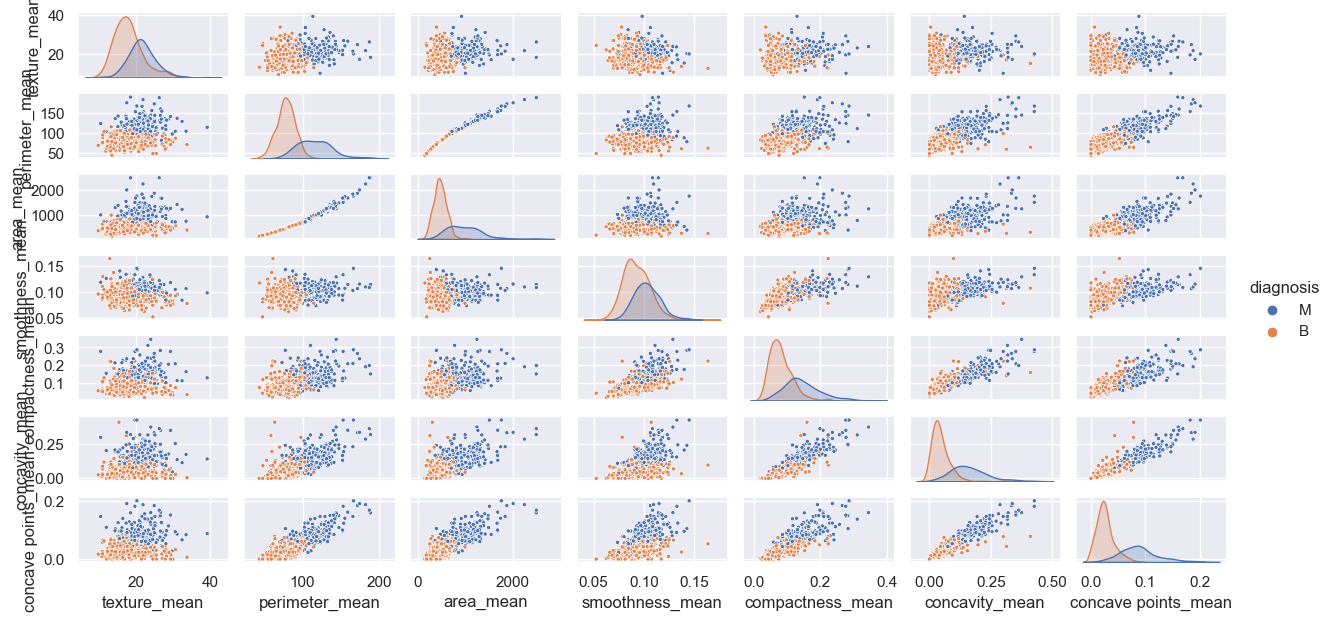

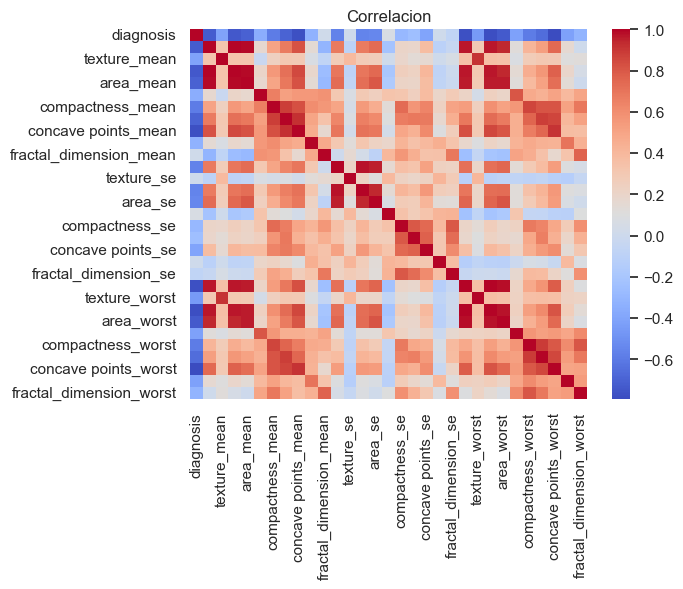

In [3]:
# Seteo de variables
# -----------------------------------------------------------------------------
#url_file = 'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRBG/data/colors.csv'
url_file = 'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBCD/data/data.csv'
# 0. Carga de datos 
# -----------------------------------------------------------------------------
data_bcd = pd.read_csv(url_file)

# 1. Exploración inicial
df = data_bcd.copy()
namecols = df.columns
df = df.drop(['id','Unnamed: 32'],axis=1)
print(df.info())

# 2. Visualizacion de datos cols respecto al tiempo y
sns.pairplot(df,vars=df.columns[2:9],markers='.',diag_kind='kde',hue='diagnosis',height=.9,aspect=2)

# se convierten datos categoricos 
(y_int,y_label) = pd.factorize(df['diagnosis'])
df['diagnosis'] = y_int

# -----------------------------------------------------------------------------
# 3. Analisis de correlación
# C2. Análisis de outliers (curacion)
corr_matrix = df.corr()
#print(corr_matrix)

fig,ax=plt.subplots();
sns.heatmap(corr_matrix,cmap='coolwarm',ax=ax)
ax.set_title('Correlacion');

# Preparacion de los datos
# -----------------------------------------------------------------------------
prop_test_size = 0.3
target = 'diagnosis'
X = df.drop(target,axis=1); X = np.array(X);
y = df[target]; y = np.array(y);

# Estandarización (media cero y variancia 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prop_test_size)
print('Son {} datos para entrenamiento y {} datos para prueba'.
      format(X_train.shape[0], X_test.shape[0]))


## Modelo KNN - seteo y crossvalidación

Tiempo ajuste del modelo:  29219.654 [ms]

Mejor elección del parametro es:  {'n_neighbors': 3}
Score alcanzado(f1): 96.71% 

Modelo optimo  - Metricas por clase 

Métricas sobre el data de entrenamiento 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       148
           1       0.97      1.00      0.98       250

    accuracy                           0.98       398
   macro avg       0.98      0.97      0.98       398
weighted avg       0.98      0.98      0.98       398

Métricas sobre el data de testeo 
               precision    recall  f1-score   support

           0       0.98      0.89      0.93        64
           1       0.94      0.99      0.96       107

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



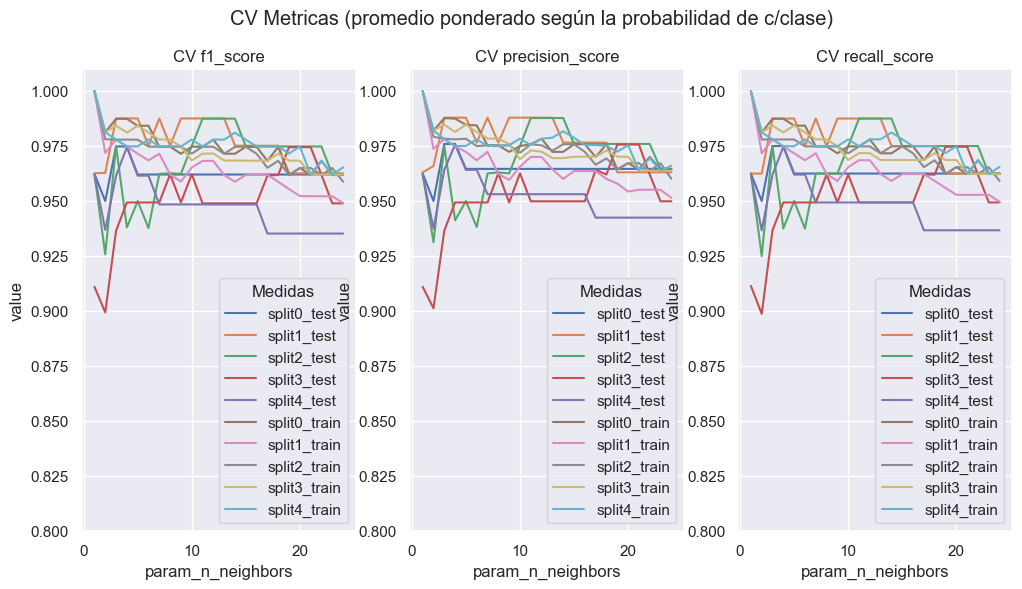

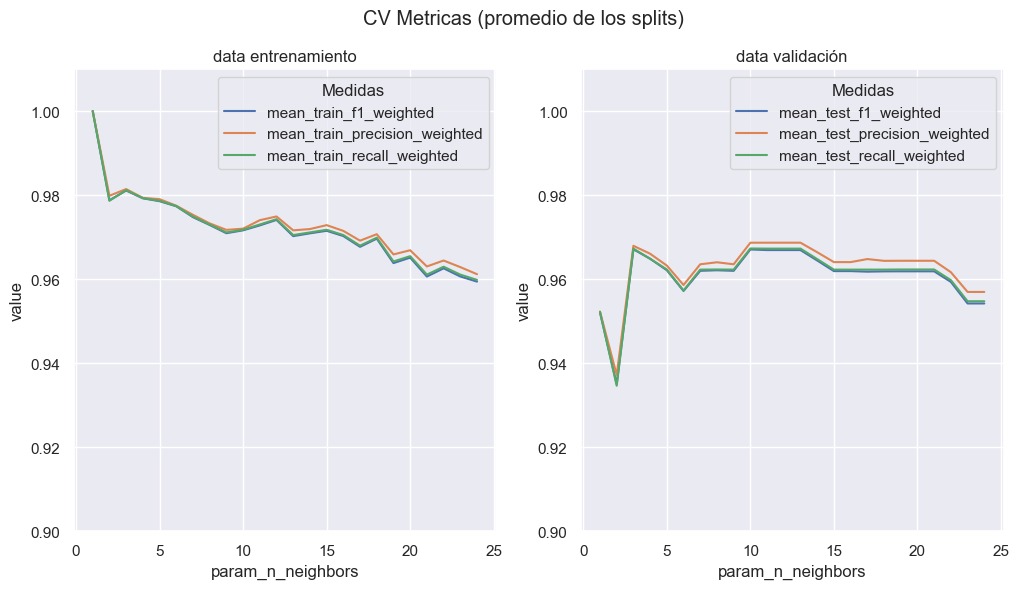

In [4]:
# =============================================================================
# Modelo KNN - seteo y crossvalidation
# =============================================================================
t1 = time.time();
knn = KNeighborsClassifier()
k_range = list(range(1, 25))
param_grid = dict(n_neighbors=k_range)

# Validación cruzada
n_splits = 5
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    knn, param_grid,cv=n_splits,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit='f1_weighted', return_train_score=True, verbose=0);
# Ajuste
grid.fit(X_train, y_train);
t2 = time.time();
# Metricas y plots
metricasyplots(grid)
print('Tiempo ajuste del modelo: ', 1000*round(t2-t1,6),'[ms]\n')
# Resultados
model_opt,grid_cv = resultados(grid)



## Modelo RandomForest - seteo y crossvalidación

Tiempo ajuste del modelo:  13574.563 [ms]

Mejor elección del parametro es:  {'n_estimators': 25}
Score alcanzado(f1): 96.99% 

Modelo optimo  - Metricas por clase 

Métricas sobre el data de entrenamiento 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       250

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398

Métricas sobre el data de testeo 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94        64
           1       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



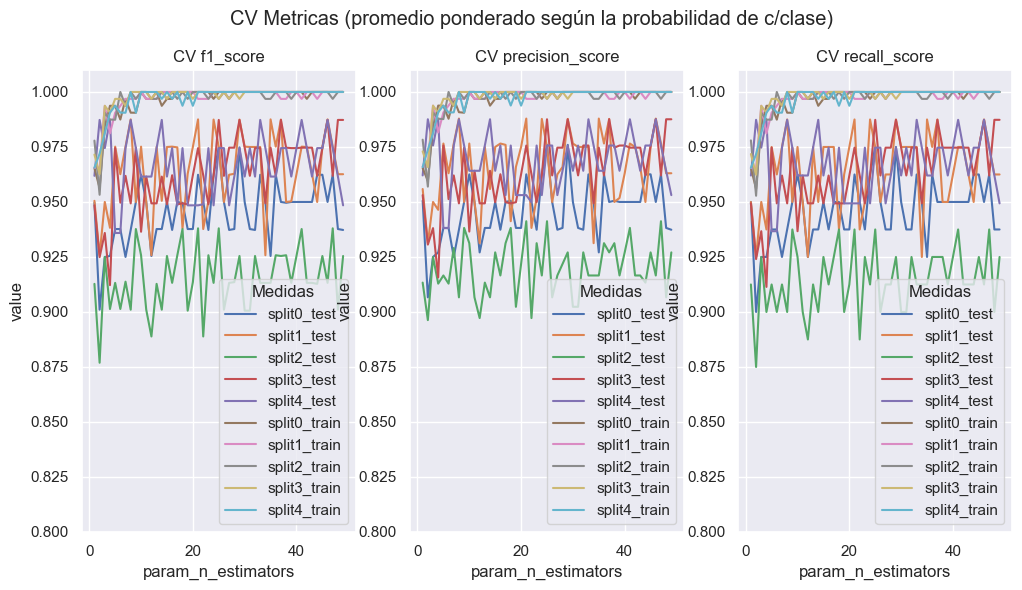

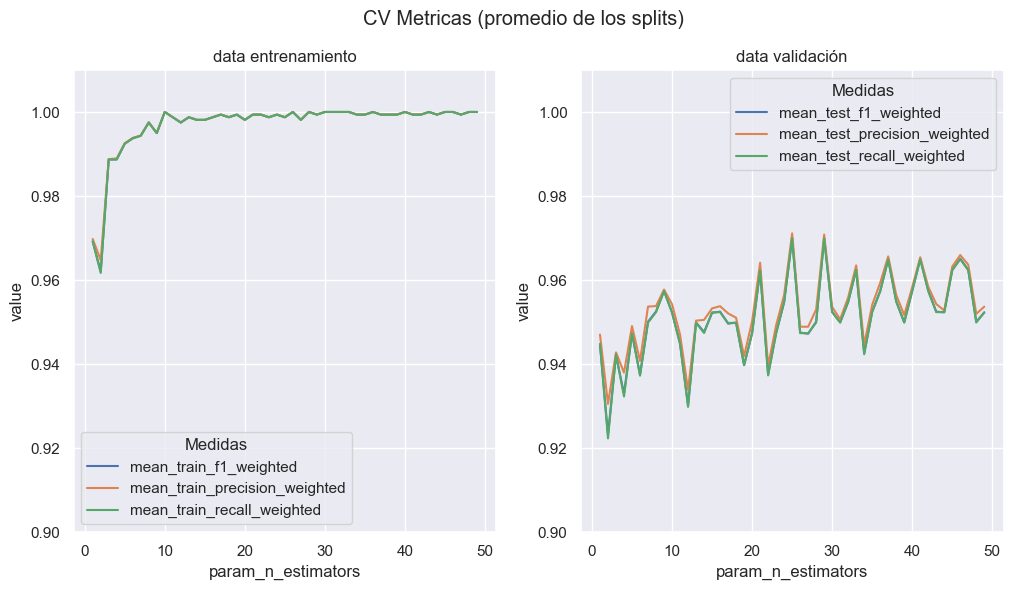

In [5]:
#%%
# =============================================================================
# Modelo RandomForest - seteo y crossvalidation
# =============================================================================
t1 = time.time();
rf = RandomForestClassifier()
k_arboles = list(range(1, 50))
param_grid = dict(n_estimators=k_arboles)

# Validación cruzada
n_splits = 5
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    rf, param_grid,cv=n_splits,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit='f1_weighted', return_train_score=True, verbose=0);
# Ajuste
grid.fit(X_train, y_train);
t2 = time.time();
# Metricas y plots

metricasyplots(grid)
print('Tiempo ajuste del modelo: ', 1000*round(t2-t1,6),'[ms]\n')
# Resultados
model_opt,grid_cv = resultados(grid)


## Modelo SVC - seteo y crossvalidación

Tiempo ajuste del modelo:  1104.762 [ms]

Mejor elección del parametro es:  {'C': 1.8329807108324356}
Score alcanzado(f1): 97.46% 

Modelo optimo  - Metricas por clase 

Métricas sobre el data de entrenamiento 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       148
           1       0.98      1.00      0.99       250

    accuracy                           0.98       398
   macro avg       0.98      0.98      0.98       398
weighted avg       0.98      0.98      0.98       398

Métricas sobre el data de testeo 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93        64
           1       0.93      1.00      0.96       107

    accuracy                           0.95       171
   macro avg       0.97      0.94      0.95       171
weighted avg       0.96      0.95      0.95       171



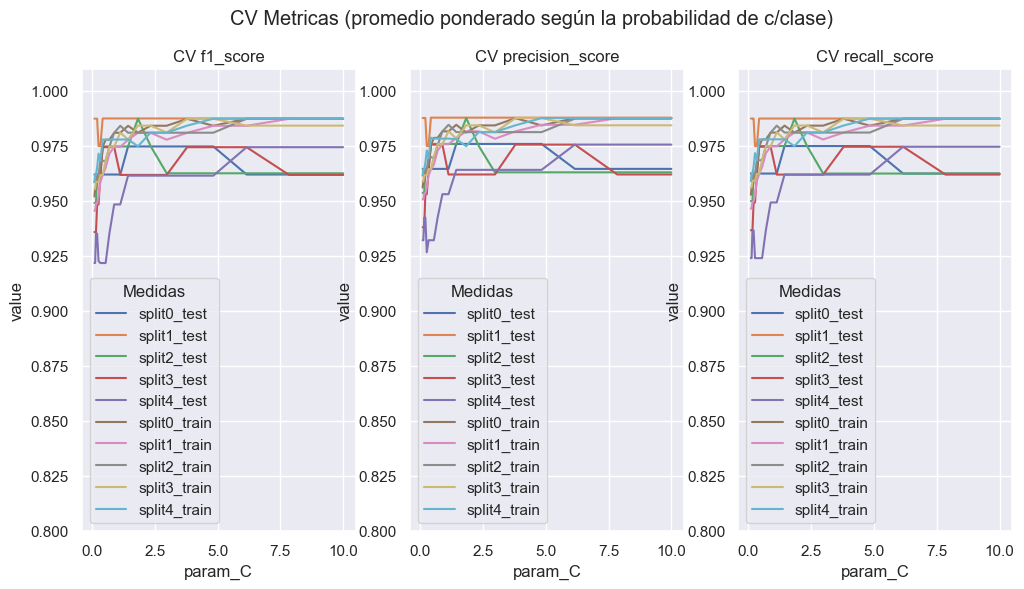

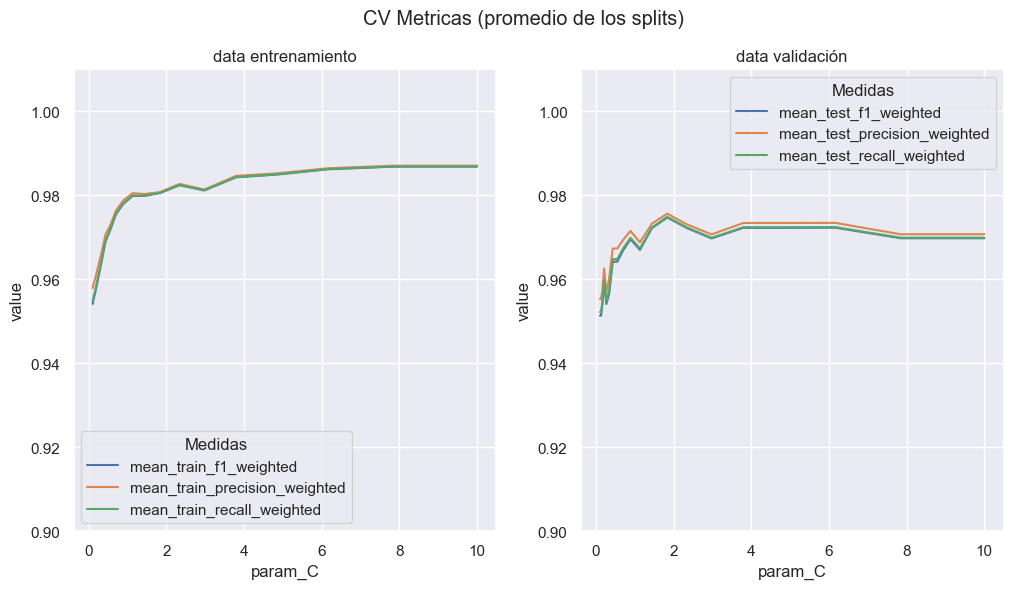

In [6]:
#%%
# =============================================================================
# Modelo SVN - seteo y crossvalidation
# =============================================================================
t1 = time.time();
svm_gausiano = SVC(kernel= "rbf", gamma=.01)
value_C = np.logspace(-1, 1, 20)
#value_C = np.linspace(1, 10, 20)
param_grid = dict(C=value_C)

# Validación cruzada
n_splits = 5
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    svm_gausiano, param_grid,cv=n_splits,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit='f1_weighted', return_train_score=True, verbose=0);
# Ajuste
grid.fit(X_train, y_train);
t2 = time.time();
# Metricas y plots
metricasyplots(grid)
print('Tiempo ajuste del modelo: ', 1000*round(t2-t1,6),'[ms]\n')
# Resultados
model_opt,grid_cv = resultados(grid)

## Modelo Regresión Logistica - seteo y crosvalidación

Tiempo ajuste del modelo:  3563.08 [ms]

Mejor elección del parametro es:  {'C': 0.9102981779915218}
Score alcanzado(f1): 97.98% 

Modelo optimo  - Metricas por clase 

Métricas sobre el data de entrenamiento 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       148
           1       0.98      1.00      0.99       250

    accuracy                           0.99       398
   macro avg       0.99      0.98      0.99       398
weighted avg       0.99      0.99      0.99       398

Métricas sobre el data de testeo 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        64
           1       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



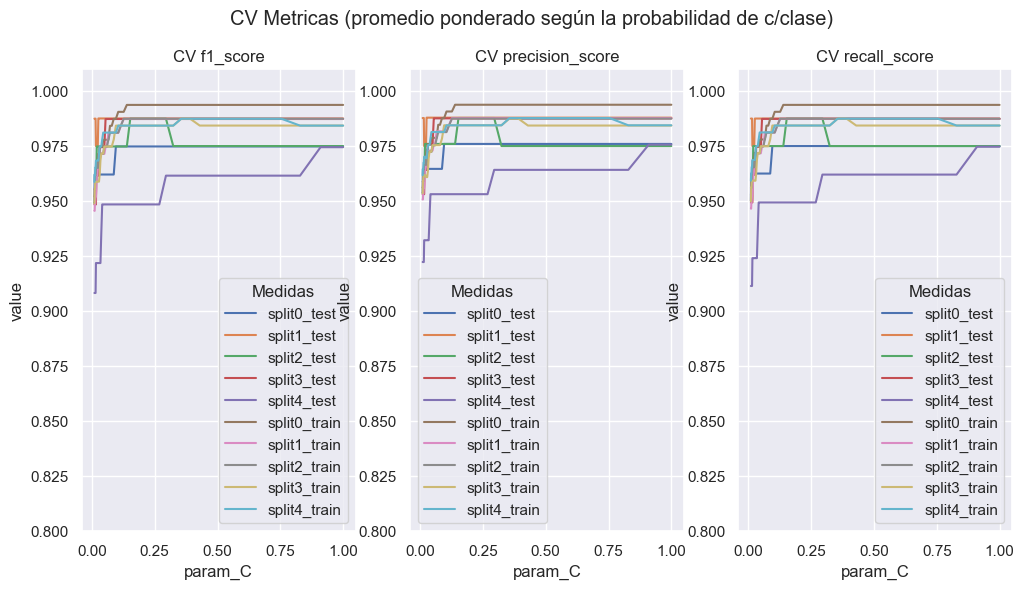

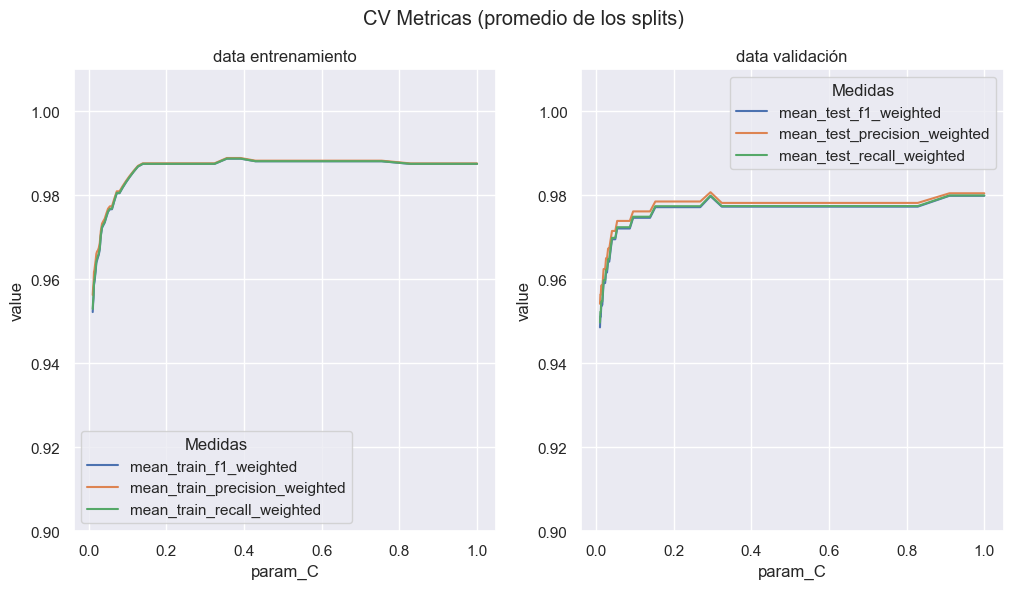

In [7]:
#%%
# =============================================================================
# Modelo Regresión Logistica - seteo y crossvalidation
# =============================================================================
t1 = time.time();
regresion_logistica = LogisticRegression(penalty='l2',solver='saga')
value_C = np.logspace(-2, 0, 50)
param_grid = dict(C=value_C)

# Validación cruzada
n_splits = 5
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    regresion_logistica, param_grid,cv=n_splits,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit='f1_weighted', return_train_score=True, verbose=0);
# Ajuste
grid.fit(X_train, y_train);
t2 = time.time();
# Metricas y plots
metricasyplots(grid)
print('Tiempo ajuste del modelo: ', 1000*round(t2-t1,6),'[ms]\n')
# Resultados
model_opt,grid_cv = resultados(grid)

## Contraste entre los cuatro modelos analizados 

In [9]:
resumen = [
['tiempo ajuste modelo[seg]',  29.21,	13.57,   1.10,	3.56],
['mejor valor parametro',       3,	     25,     1.83,	0.91],
['Score f1 (datatrain)[%]',     0.98,	1.0,      0.98,	0.99],
['Score f1 (datatest)[%]',      0.95,   0.96,	0.95,	0.96]]
resumen = pd.DataFrame(resumen,
             columns=[' ','KNN','RandomForest','SVC','Regresión Logistica'])
resumen

,,KNN,RandomForest,SVC,Regresión Logistica
0,tiempo ajuste modelo[seg],29.21,13.57,1.10,3.56
1,mejor valor parametro,3.00,25.00,1.83,0.91
2,Score f1 (datatrain)[%],0.98,1.00,0.98,0.99
3,Score f1 (datatest)[%],0.95,0.96,0.95,0.96
